# ML-7. Прогнозирование биологического ответа (HW-3)
#### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from scipy.stats import randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

C:\Users\trigubov\AppData\Local\Temp\ipykernel_12672\2538845368.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#загрузим данные, посмотрим на них
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


#### Предварительная обработка не требуется, данные уже закодированы и нормализованы.

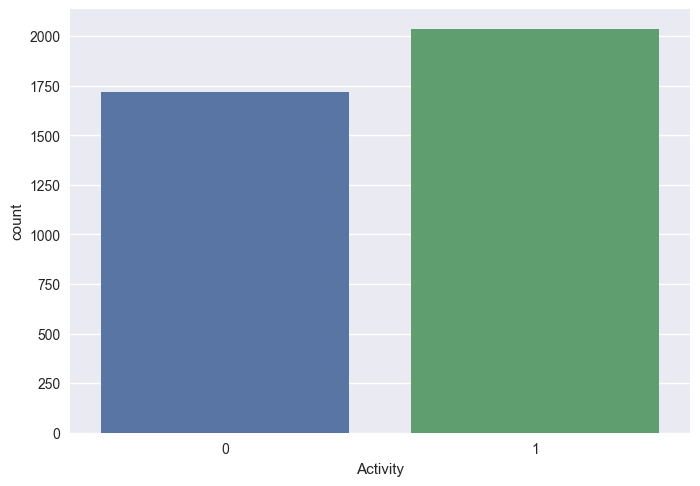

In [3]:
# Посмотрим на сбалансированность классов
sns.countplot(data=data, x='Activity');

Хорошо. Можнор сказать, что данные сбалансированы.

In [4]:
# создадим матрицу наблюдений и матрицу ответов
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделим выборку на тренировочную и тестовую в соотношении 80/20. Хоть мы и будем использовать кросс-валидацию, мы так-же будем использовать отдельную тестовую выборку, для контроля

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Базовые модели
Для начала построим базовые модели, с настройками по умолчанию, что-бы было с чем сравнивать результаты подборок гиперпараметров

In [6]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000,random_state=42)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('Логистическая регрессия. f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Логистическая регрессия. f1_score на тестовом наборе: 0.79


In [7]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('Случайный лес. f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Случайный лес. f1_score на тестовом наборе: 0.83


Базовые модели показали уже доввольно неплохие результаты. Посмотрим, как мы сможем их улучшить, используя различные методы подбора гиперпараметров

## Метод GridSearchCV

### Логистическая регрессия

In [9]:
param_grid = [{'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': [0.01, 0.1, 0.2, 0.4, 0.8, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': [0.01, 0.1, 0.2, 0.4, 0.8, 1]
              }
            ]

# 2 * 2 * 6   +  2 * 2 * 6 = 48 итераций. Количество итераций не превышает требуемые 50

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid,
    scoring='f1', # наша целевая метрика, по которой ведётся поиск
    cv=5, # количество кросс-валидаций
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

y_test_pred = grid_search.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))


CPU times: total: 5.81 s
Wall time: 12min 37s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


Перебрав все возможные варианты (48 штук) метрику F1 не удалось улучшить. Как было с дефолтными настройками 0.79, так и осталось

### Случайный лес

In [10]:
param_grid = {'min_samples_leaf': [1,10,50],
              'max_depth': [6,7,8,9],
              'criterion':['entropy','gini'],
              'n_estimators': [32,64], # количество деревьев в лесу
              }

# 3 * 4 * 2 * 2 = 48 возможных итераций. Это меньше максимального значения по условиям задачи

grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid,
    scoring='f1', # наша целевая метрика, по которой ведётся поиск
    cv=5, # количество кросс-валидаций
    n_jobs = -1
)

%time grid_search_tree.fit(X_train, y_train) 

y_test_pred = grid_search_tree.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 1.28 s
Wall time: 23.7 s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 32}


Метрику F1 для случайного леса так-же не удалось улучшить. Но это и неудивительно. Мы заранее не знаем какие параметры нам подойдут, и взяли первые, примерно подходящие в параметрах, которые более-менее сильно влияют на результат. А перебирать вообще все возможные варианты всех возможных гиперпараметров - задача займёт огромное количество времени. 

## Метод RandomSearchCV

С RandomSearchCV ситуация чуть получше. Мы смогли охватить намного больше гиперпараметров и их значений, ограничив лишь максимумом в 50 количество возможных случайных комбинаций.

### Логистическая регрессия

In [11]:
param_distributions = [{'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga','newton-cg','newton-cholesky'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 20, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': list(np.linspace(0.01, 1, 10, dtype=float))
              }
            ]
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5,
    scoring='f1', # наша целевая метрика, по которой ведётся поиск
    n_iter = 50, 
    n_jobs = -1,
    random_state=42
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 15.1 s
Wall time: 14min 36s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.06210526315789474}


### Случайный лес

In [15]:
param_distributions = {'n_estimators': list(range(8, 128, 8)),
              'min_samples_leaf': randint(1,100),
              'max_depth': np.arange(5,15),
              'criterion': ['entropy','gini'],
              'max_features': ['sqrt', 'log2'],
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50,
    n_jobs = -1,
    random_state=42
)  
%time random_search_forest.fit(X_train, y_train) 

y_train_pred = random_search_forest.predict(X_train)

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.47 s
Wall time: 23.9 s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 96}


Метрику всё еще не удалось улучшить, однако, возможности случайного перебора заметно выше - мы охватили значительно больше гиперпараметров и их значений при том-же количестве итераций.

## Hyperopt

Я очень пытался разобраться, как для линейной регрессии сделать разные параметры solver, в зависимости от типа penalty, как мы это делали для GridSearchCV и RandomizedSearchCV. Тут это как-то очень непросто. Надеюсь, у меня получилось. Еле нашёл решение. Недостаток примеров и документации по Hyperopt - удручает

### Линейная регрессия

In [148]:
# зададим пространство поиска гиперпараметров

solvers1 = ["newton-cg", "lbfgs", ]
solvers2 = ["liblinear", ]
#solvers3 = ["saga", ]
penalties1 = ["l2", "none"]
penalties2 = ["l1", "l2"]
#penalties3 = ["l1", "elasticnet", "l2"]

case1 = {
        "penalty1": hp.choice("penalty1", penalties1),
        "solver1": hp.choice("solver1", solvers1)
}
case2 = {
        "penalty2": hp.choice("penalty2", penalties2),
        "solver2": hp.choice("solver2", solvers2)
}
#case3 = {
#        "penalty3": hp.choice("penalty3", penalties3),
#        "solver3": hp.choice("solver3", solvers3)
#}

space = {
    'C': hp.loguniform(label='C', low=-4*np.log(10), high=2*np.log(10)),    
    "cases" : hp.choice("cases", [("case1", case1), ("case2", case2)])
}

In [164]:
def hyperopt_lr(params_, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"    
   
    C = params_["C"]
    kwds = params_["cases"]
    

    penalty = kwds[1]["penalty1"] if kwds[0] == "case1" else kwds[1]["penalty2"] if kwds[0] == "case2" else kwds[1]["penalty3"]
    solver = kwds[1]["solver1"] if kwds[0] == "case1" else kwds[1]["solver2"] if kwds[0] == "case2" else kwds[1]["solver3"]   

    # print (C,penalty,solver)
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(C=C,
                                            penalty=penalty,
                                            solver=solver,
                                            random_state=42,
                                            max_iter=1000)
        
    # обучим модель с помощью кросс валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()    

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [165]:
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов          
          rstate=np.random.default_rng(42)
         )


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [09:15<00:00, 11.11s/trial, best loss: -0.7849656593895886]


In [166]:

C = best["C"]

if best["cases"] == 0:
    penalty = penalties1[best["penalty1"]]
    solver = solvers1[best["solver1"]]
elif best["cases"] == 1:
    penalty = penalties2[best["penalty2"]]
    solver = solvers2[best["solver2"]]
#elif best["cases"] == 2:
#    penalty = penalties3[best["penalty3"]]
#    solver = solvers3[best["solver3"]]

model = linear_model.LogisticRegression(C=C,
                                            penalty=penalty,
                                            solver=solver,
                                            random_state=50,
                                            max_iter=1000)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print("Наилучшие значения гиперпараметров : {}".format({"C":C,
                                                   "penalty": penalty,                                                   
                                                   "solver":solver,
                                                  }))

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров : {'C': 0.07037368830919978, 'penalty': 'l2', 'solver': 'newton-cg'}
f1_score на тестовом наборе: 0.79


### Случайный лес

In [167]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
       'max_depth' : hp.quniform('max_depth', 5, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [169]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [171]:
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата !!! Это старый вариант!!!
          rstate=np.random.default_rng(42)
         )

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [02:24<00:00,  2.89s/trial, best loss: -0.8117589362318096]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 165.0}


In [173]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.84


Подведу вывод - HyperOpt - довольно неинтуитивная, и неудобная конструкция оптимизации, которая, судая по всему, не пользуется особой популярностью.
Линейную регрессию ей улучшить не удалось, случайный леc смогли слегка улучшить с 0.83 до 0.84

Хорошо, что есть Optuna. Ей работать намного удобней.

## Optuna

### Логистическая регрессия

In [44]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  
  C = trial.suggest_float('C', 0.001, 1, log=True)
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'none'])
  
  
  solver1 = trial.suggest_categorical('solver1', ['liblinear', 'saga'])
  solver2 = trial.suggest_categorical('solver2', ['liblinear', 'saga', 'lbfgs'])
  solver3 = trial.suggest_categorical('solver3', ['saga', 'lbfgs'])
  
  if penalty == 'l1':
    solver = solver1
  elif penalty == 'l2':
    solver = solver2
  elif penalty == 'none':
    solver = solver3    
  
  
  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          max_iter=1000,
                                          random_state=42)
    
  #обучаем модель с помощью кросс-валидации
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  
  
  # !!! а вот я еще так делал, и так быстрее в 5 раз !!!
  # обучаем модель получая метрику сразу с тестовой выборки, а не с кросс-валидации тренировочной
  
  #model.fit(X_train, y_train)
  #score = metrics.f1_score(y_test, model.predict(X_test))

  return score

In [45]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=50)

[I 2023-09-18 14:55:51,626] A new study created in memory with name: LogisticRegression
[I 2023-09-18 14:56:25,624] Trial 0 finished with value: 0.7837306935843991 and parameters: {'C': 0.11031004517779804, 'penalty': 'l1', 'solver1': 'saga', 'solver2': 'liblinear', 'solver3': 'saga'}. Best is trial 0 with value: 0.7837306935843991.
[I 2023-09-18 14:56:51,105] Trial 1 finished with value: 0.7222774173467272 and parameters: {'C': 0.10800550254432363, 'penalty': 'none', 'solver1': 'liblinear', 'solver2': 'saga', 'solver3': 'lbfgs'}. Best is trial 0 with value: 0.7837306935843991.
[I 2023-09-18 14:56:58,458] Trial 2 finished with value: 0.7739117435780123 and parameters: {'C': 0.004053851084809973, 'penalty': 'l2', 'solver1': 'liblinear', 'solver2': 'saga', 'solver3': 'saga'}. Best is trial 0 with value: 0.7837306935843991.
[I 2023-09-18 14:57:00,225] Trial 3 finished with value: 0.7786337204019699 and parameters: {'C': 0.5881969132957474, 'penalty': 'l2', 'solver1': 'saga', 'solver2': 'l

In [52]:
C = study.best_params['C']
penalty = study.best_params['penalty']
if penalty == 'l1':
    solver = study.best_params['solver1']
elif penalty == 'l2':
    solver = study.best_params['solver2']
elif penalty == 'none':
    solver = study.best_params['solver3']    

In [54]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(C=C,
                                        penalty=penalty,
                                        solver=solver,
                                        random_state=42, max_iter=1000 )

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


Не очень понятен смысл использования алгоритма кросс-валидации в данном случае, если есть возможность получать метрику сразу проверяя тестовую выборку (закоменнтированная часть). Время обработки при использовании кросс-валидации увеличивается в 5 раз, а на результат не влияет. Хотелось-бы комментарий ментора.

### Случайный лес

In [55]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 300, 10)
  max_depth = trial.suggest_int('max_depth', 5, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  
  return score

In [56]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2023-09-18 15:53:12,042] A new study created in memory with name: RandomForestClassifier
[I 2023-09-18 15:53:23,255] Trial 0 finished with value: 0.7670670060855737 and parameters: {'n_estimators': 270, 'max_depth': 22, 'min_samples_leaf': 43}. Best is trial 0 with value: 0.7670670060855737.
[I 2023-09-18 15:53:28,842] Trial 1 finished with value: 0.8079169442191955 and parameters: {'n_estimators': 150, 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8079169442191955.
[I 2023-09-18 15:53:30,982] Trial 2 finished with value: 0.779451711318524 and parameters: {'n_estimators': 120, 'max_depth': 37, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.8079169442191955.
[I 2023-09-18 15:53:33,046] Trial 3 finished with value: 0.7721534920656946 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_leaf': 35}. Best is trial 1 with value: 0.8079169442191955.
[I 2023-09-18 15:53:36,937] Trial 4 finished with value: 0.7793728848816392 and parameters: {'

In [57]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.83


Метрики так и не удалось улучшить, по сравнению с базовыми моделями, но, думаю, это из-за того, что мы взяли большое количество гиперпараметров и их значений, при относительно малом количестве проб.
Впрочем, уже можно итак сказать, что метод Optuna - наиболее удобный и быстрый способ оптимизации гиперпараметров.